@ Puran Zhang
## Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!

## Goal
You are asked to:

1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

2. Explain why that might be happening. Are the localized translations really worse?

3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Data Loading

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import ttest_ind

import os
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
os.getcwd()
path1 = '/Users/puran/Downloads/Data Science/Take_home_challenge/Spanish Translation A/Translation_Test/test_table.csv'
test = pd.read_csv(path1, parse_dates=['date'])
# parse_dates: bool or list of int or names or list of lists or dict, default False
path2 = '/Users/puran/Downloads/Data Science/Take_home_challenge/Spanish Translation A/Translation_Test/user_table.csv'
user = pd.read_csv(path2)

In [3]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           453321 non-null  int64         
 1   date              453321 non-null  datetime64[ns]
 2   source            453321 non-null  object        
 3   device            453321 non-null  object        
 4   browser_language  453321 non-null  object        
 5   ads_channel       181877 non-null  object        
 6   browser           453321 non-null  object        
 7   conversion        453321 non-null  int64         
 8   test              453321 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 31.1+ MB


In [5]:
#  test['date']=pd.to_datetime(test['date'], format="%Y-%m-%d")

In [6]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [7]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [8]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [9]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


## Data Processing

In [10]:
# check user id
print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique())==len(test))
# check user id
print('Test ID:\t', len(user['user_id'].unique()), '\t', len(user['user_id'].unique())==len(user))


Test ID:	 453321 	 True
Test ID:	 452867 	 True


In [11]:
# merge two tables
data = pd.merge(left = test, right= user,  how = 'left', on = 'user_id')
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           453321 non-null  int64         
 1   date              453321 non-null  datetime64[ns]
 2   source            453321 non-null  object        
 3   device            453321 non-null  object        
 4   browser_language  453321 non-null  object        
 5   ads_channel       181877 non-null  object        
 6   browser           453321 non-null  object        
 7   conversion        453321 non-null  int64         
 8   test              453321 non-null  int64         
 9   sex               452867 non-null  object        
 10  age               452867 non-null  float64       
 11  country           452867 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


## A/B Testing

In [13]:
# Firstly, check that Spain converts better than the rest of LatAm countries
groupby_country = data[data['test']==0][['conversion', 'country']].groupby('country').mean()
# print(groupby_country)
# When reset the index, the old index is added as a column, and a new sequential index is used
groupby_country = groupby_country.reset_index()
# print(groupby_country)
groupby_country = groupby_country.sort_values('conversion', ascending=False)

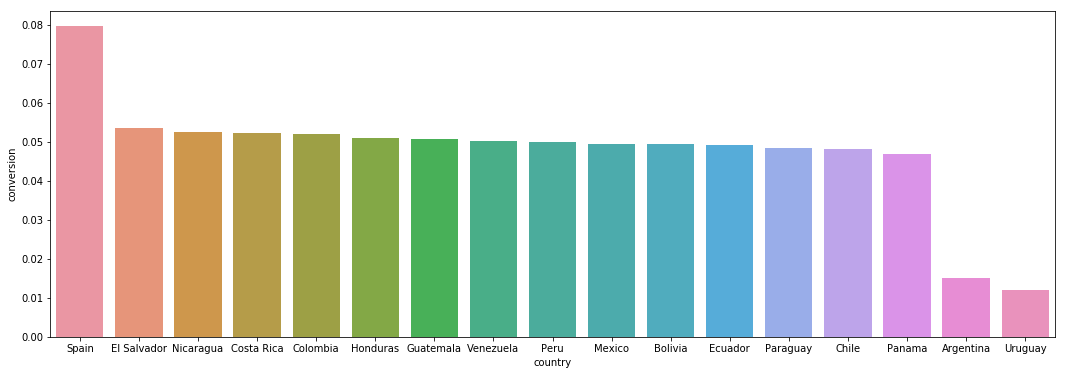

In [14]:
# Visualization
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.show()

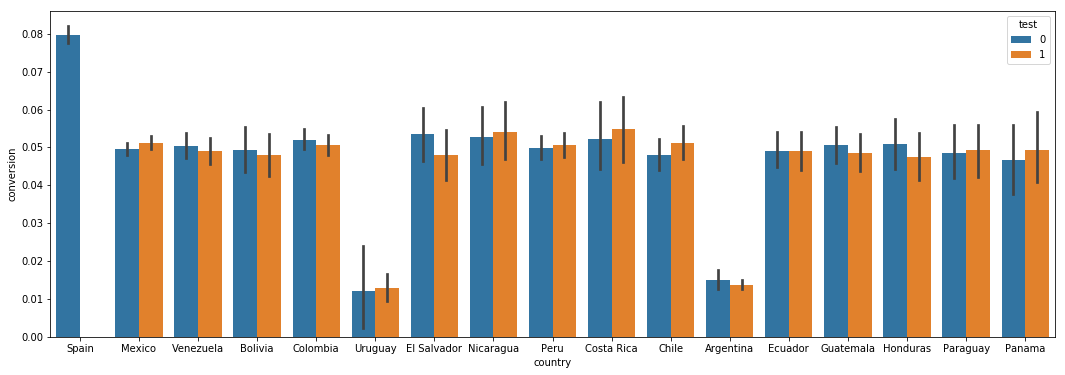

In [15]:
# overall visualization
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x='country', y='conversion', hue= 'test', data=data, ax=ax)
#Colors to use for the different levels of the hue
plt.show()

In [16]:
# A/B Testing
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test']==1]['conversion'].values
# .values convert to array
cont_val = test_data[test_data['test']==0]['conversion'].values
print(test_val.mean(), '\t', cont_val.mean())

0.043424713982118966 	 0.04833042316066309


In [17]:
ttest_ind(test_val, cont_val, equal_var=False)

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)

The two-sample t-test for unpaired data is defined as:<br>
H0:	μ1=μ2 <br>
Ha:	μ1≠μ2<br>
P-value < 0.05<br>

Well, it seems that local-translation make it even worse

Mmh…not in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. 

The most likely reason for weird A/B test results are:
1. We didn’t collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not really random.

## Analysis
In data science, whenever results appear too bad or too good to be true, they are not true.

In [18]:
test_data= data[data['country'] != 'Spain']
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


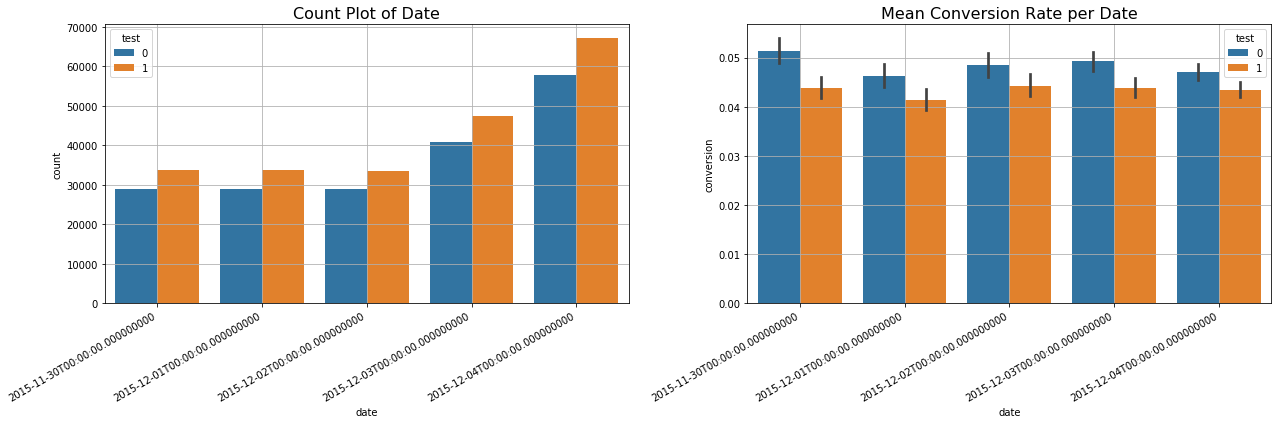

In [19]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='date',hue='test',data=test_data, ax=ax[0])

#myFmt = mdates.DateFormatter('%Y%m%d') 
#ax[0].xaxis.set_major_formatter(myFmt)

ax[0].set_title('Count Plot of Date', fontsize=16) 
ax[0].grid(True)


sns.barplot(x='date', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
ax[1].grid(True) 

fig.autofmt_xdate()
# axes up to make room for them
plt.tight_layout()
# Adjust the padding between and around subplots.
plt.show()

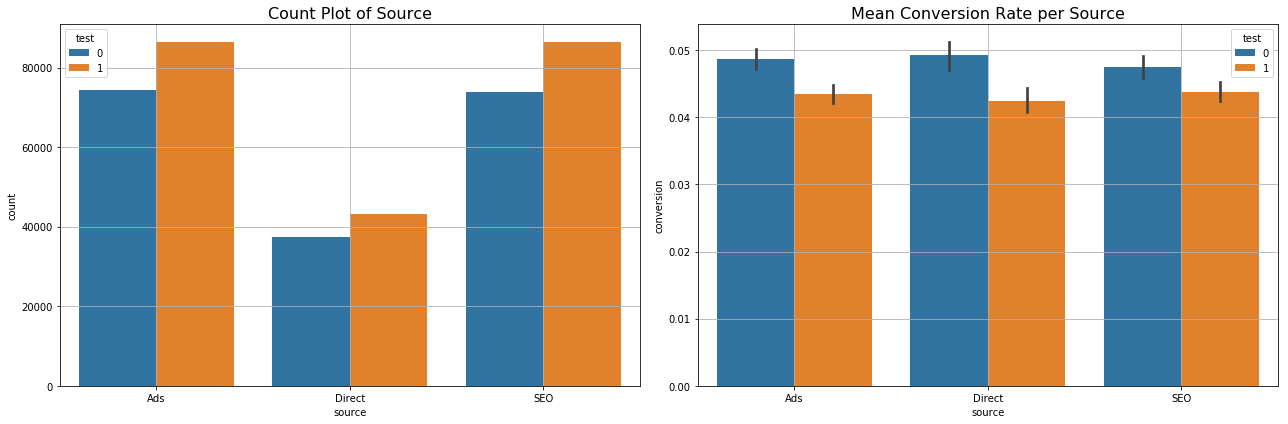

In [20]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)
ax[0].grid(True) 

sns.barplot(x='source', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
ax[1].grid(True)

#fig.autofmt_xdate()
plt.tight_layout()
plt.show()

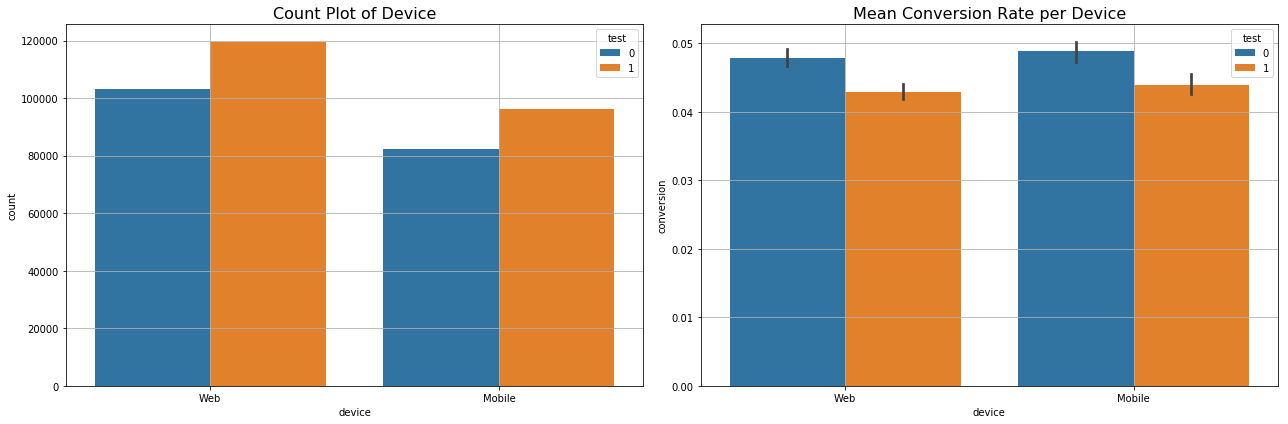

In [21]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)
ax[0].grid(True) 

sns.barplot(x='device', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
ax[1].grid(True) 

#fig.autofmt_xdate()
plt.tight_layout()
plt.show()

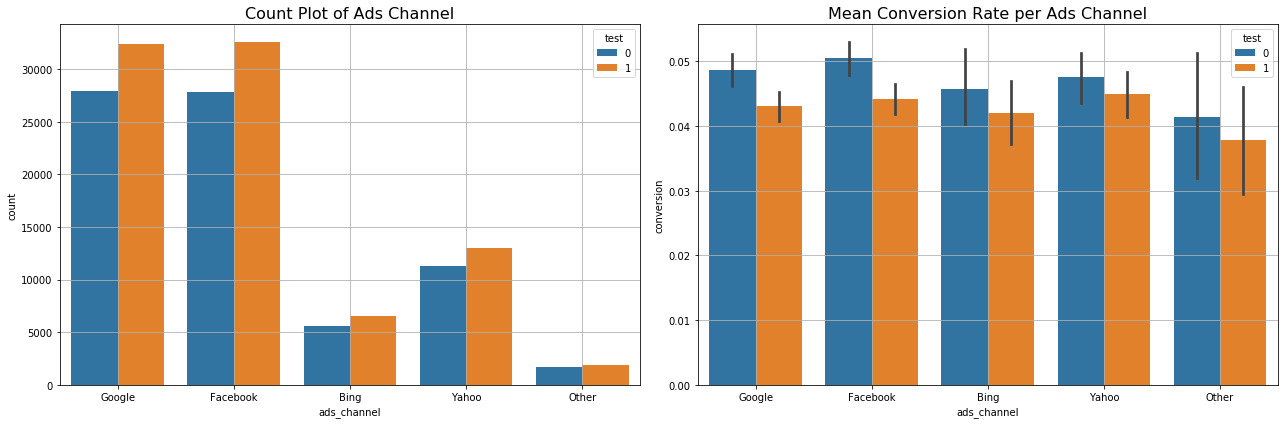

In [22]:
# Visualization of ads channel
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)
ax[0].grid(True) 

sns.barplot(x='ads_channel', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
ax[1].grid(True) 

plt.tight_layout()
plt.show()

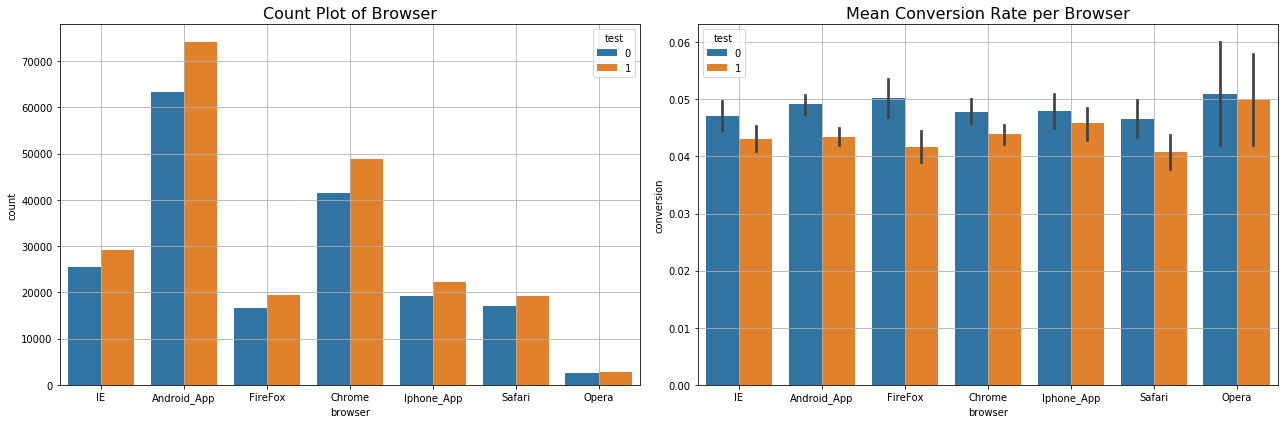

In [23]:
# Visualization of different browers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)
ax[0].grid(True) 

sns.barplot(x='browser', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Browser', fontsize=16)
ax[1].grid(True) 

plt.tight_layout()
plt.show()

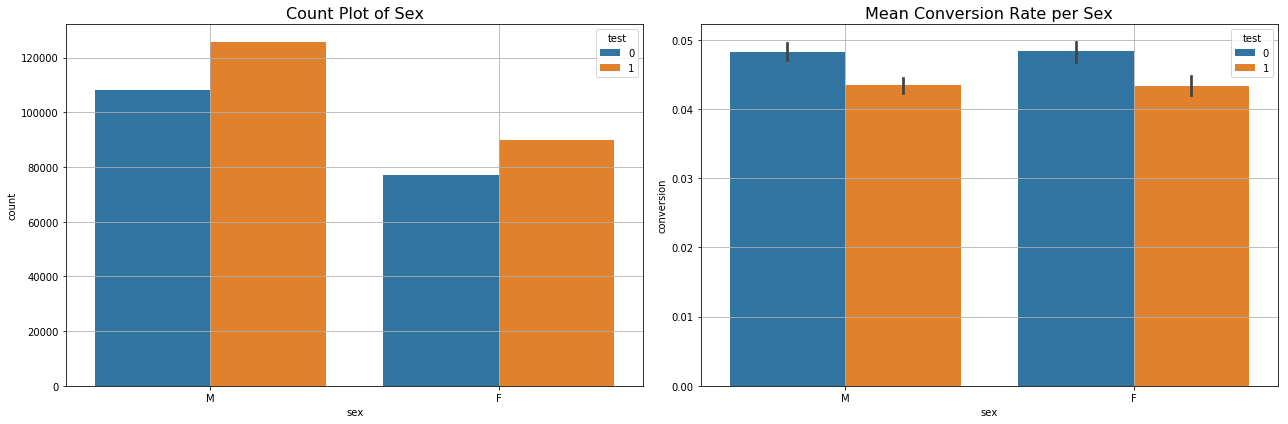

In [24]:
# Visualization of different sex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)
ax[0].grid(True)

sns.barplot(x='sex', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
ax[1].grid(True) 
plt.tight_layout()
plt.show()

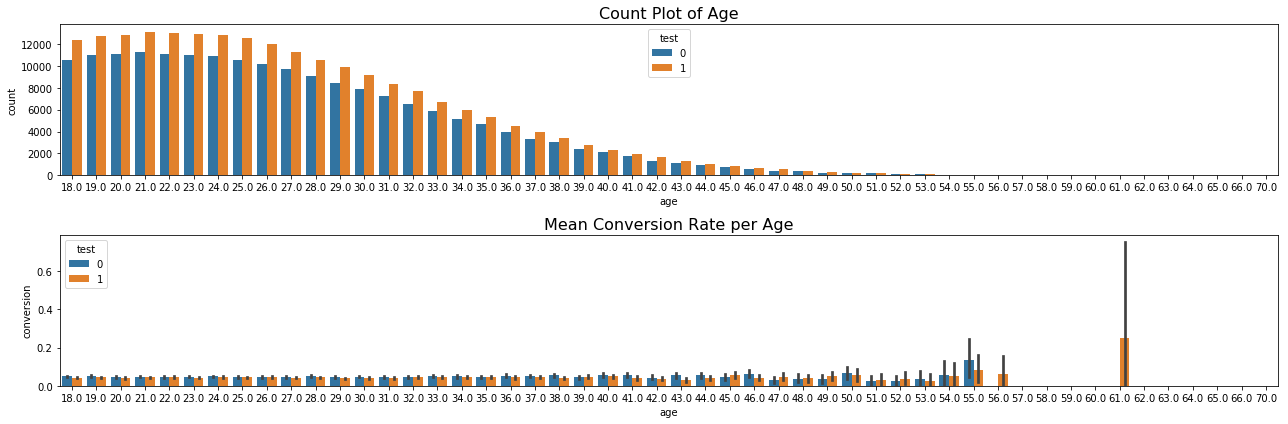

In [25]:
# Visualization of different ages
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 6))
sns.countplot(x='age', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Age', fontsize=16)

sns.barplot(x='age', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Age', fontsize=16)
plt.tight_layout()
plt.show() 

From the plot, we notice a couple of things:

1. Test has constantly been worse than control and there is relatively little variance across days. Thatprobably means that we do have enough data, but there was some bias in the experiment set up.

2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.

Time to find out the bias! Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall
results.


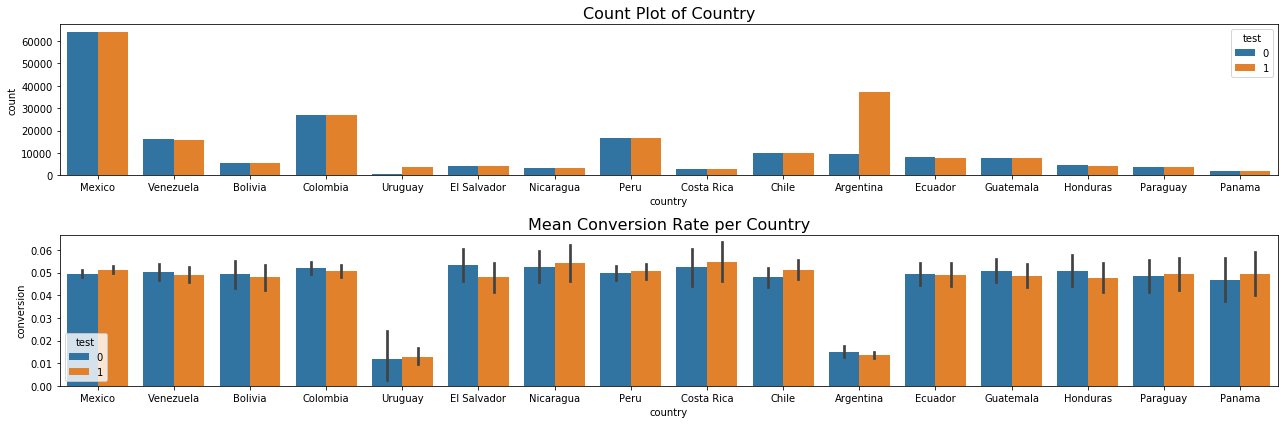

In [26]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=test_data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='country', y='conversion', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

In an ideal world, the distribution of people in test and control for each segment should be the same.There are many ways to this. One way is to build a decision tree where the variables are the userdimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).

let’s check the test results after controlling for country. That is, we check for each country how the test is doing:

In [35]:
countries = [name for name in data['country'].unique() if name is not np.nan]
print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country','Test Rate','Control Rate','P-Value'))
# > Left aligns the result
# < Right aligns the result
print('-'* 65)
for country in countries:
    test_val =  test_data[(test_data['country']== country)&(test_data['test']==1)]['conversion'].values
    cont_val =  test_data[(test_data['country']== country)&(test_data['test']==0)]['conversion'].values
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10.5f}'.format(country, test_mean, cont_mean, p_val))


Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Spain                       nan             nan        nan
Mexico                  0.05119         0.04949    0.16554
Venezuela               0.04898         0.05034    0.57370
Bolivia                 0.04790         0.04937    0.71889
Colombia                0.05057         0.05209    0.42372
Uruguay                 0.01291         0.01205    0.87976
El Salvador             0.04795         0.05355    0.24813
Nicaragua               0.05418         0.05265    0.78040
Peru                    0.05060         0.04991    0.77195
Costa Rica              0.05474         0.05226    0.68788
Chile                   0.05130         0.04811    0.30285
Argentina               0.01373         0.01507    0.33515
Ecuador                 0.04899         0.04915    0.96151
Guatemala               0.04865         0.05064    0.57211
Honduras                0.04754         0.05091  

After we control for country, the test clearly appears non significant. Not a great success given that the
goal was to improve conversion rate, but at least we know that a localized translation didn’t make things
worse!